<a href="https://colab.research.google.com/github/maanitmehta/Macroeconomic_regime_allocation/blob/main/Regime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy yfinance fredapi hmmlearn scipy matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 6.0 MB/s eta 0:00:00


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
FRED_API_KEY = "e0b05c797576a3db6d0a186713a70f4d"  # ← REPLACE THIS!

# Data settings
START_DATE = '2000-01-01'
END_DATE = None  # None = today

# Model settings
N_REGIMES = 3
LOOKBACK_WINDOW = 36  # months for rolling backtest
RISK_FREE_RATE = 0.02  # 2% annual

# Output settings
SAVE_FIGURES = True
OUTPUT_DIR = 'regime_allocation_results'

In [3]:
print("="*80)
print("REGIME-AWARE ALLOCATION - STARTING PIPELINE")
print("="*80)

# Create output directory
if SAVE_FIGURES and not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"✓ Created output directory: {OUTPUT_DIR}/")

print("\n" + "="*80)
print("PART 1: DATA COLLECTION")
print("="*80)

# Check API key
if FRED_API_KEY == "YOUR_FRED_API_KEY_HERE":
    print("\n⚠️  ERROR: Please set your FRED API key!")
    print("Get one free at: https://fred.stlouisfed.org/docs/api/api_key.html")
    print("Then replace 'YOUR_FRED_API_KEY_HERE' on line 30 with your key.")
    exit()

# Import FRED
try:
    from fredapi import Fred
    fred = Fred(api_key=FRED_API_KEY)
    print("✓ FRED API connected")
except Exception as e:
    print(f"✗ FRED API error: {e}")
    exit()

# Import yfinance
try:
    import yfinance as yf
    print("✓ Yahoo Finance ready")
except ImportError:
    print("✗ Please install yfinance: pip install yfinance")
    exit()

# Fetch macro data from FRED
print("\nFetching macroeconomic data from FRED...")

if END_DATE is None:
    END_DATE = datetime.now().strftime('%Y-%m-%d')

macro_series = {
    'treasury_10y': 'DGS10',
    'treasury_3m': 'DGS3MO',
    'yield_curve': 'T10Y3M',
    'cpi': 'CPIAUCSL',
    'unemployment': 'UNRATE',
    'vix': 'VIXCLS',
    'industrial_production': 'INDPRO',
}

macro_data = {}
for name, series_id in macro_series.items():
    try:
        print(f"  Fetching {name}...", end=" ")
        macro_data[name] = fred.get_series(
            series_id,
            observation_start=START_DATE,
            observation_end=END_DATE
        )
        print("✓")
    except Exception as e:
        print(f"✗ ({e})")

# Combine into DataFrame
macro_df = pd.DataFrame(macro_data)
macro_df = macro_df.resample('M').last()  # Month-end frequency

# Calculate derived features
macro_df['inflation_yoy'] = macro_df['cpi'].pct_change(12) * 100
macro_df['ip_growth_yoy'] = macro_df['industrial_production'].pct_change(12) * 100

macro_df = macro_df.dropna()

print(f"\n✓ Macro data collected: {len(macro_df)} observations")
print(f"  Date range: {macro_df.index[0].date()} to {macro_df.index[-1].date()}")

# Fetch asset data from Yahoo Finance
print("\nFetching asset price data from Yahoo Finance...")

tickers = {
    'SPY': 'S&P 500',
    'IWM': 'Russell 2000',
    'XLU': 'Utilities',
    'XLY': 'Consumer Discretionary',
    'XLK': 'Technology',
    'XLF': 'Financials'
}

try:
    prices = yf.download(
        list(tickers.keys()),
        start=START_DATE,
        end=END_DATE,
        progress=False
    )['Close']
    prices = prices.resample('M').last()
    returns_df = prices.pct_change() * 100  # Monthly returns in %
    returns_df = returns_df.dropna()
    print(returns_df)
    returns_df.columns = [tickers[col] for col in returns_df.columns]

    print(f"✓ Asset data collected: {len(returns_df)} observations")

except Exception as e:
    print(f"✗ Error fetching asset data: {e}")
    exit()

# Align macro and returns data
common_dates = macro_df.index.intersection(returns_df.index)
macro_df = macro_df.loc[common_dates]
returns_df = returns_df.loc[common_dates]

print(f"\n✓ Data aligned: {len(common_dates)} common observations")

REGIME-AWARE ALLOCATION - STARTING PIPELINE

PART 1: DATA COLLECTION
✓ FRED API connected
✓ Yahoo Finance ready

Fetching macroeconomic data from FRED...
  Fetching treasury_10y... ✓
  Fetching treasury_3m... ✓
  Fetching yield_curve... ✓
  Fetching cpi... ✓
  Fetching unemployment... ✓
  Fetching vix... ✓
  Fetching industrial_production... ✓

✓ Macro data collected: 300 observations
  Date range: 2001-01-31 to 2026-01-31

Fetching asset price data from Yahoo Finance...
Ticker           IWM       SPY        XLF        XLK        XLU       XLY
Date                                                                     
2000-06-30  8.682707  1.968201  -4.850122   9.955594  -3.396717 -5.410168
2000-07-31 -2.766452 -1.570174   8.815820  -5.305661   1.548187  1.587277
2000-08-31  6.965221  6.534053  10.157148  10.170539   3.896093 -4.146605
2000-09-30 -3.276762 -5.486243   2.173966 -17.965693  13.214283  0.122507
2000-10-31 -4.463182 -0.467797  -0.862048  -5.727809   5.808356 -1.255471
...   

In [4]:
print("\n" + "="*80)
print("PART 2: REGIME DETECTION (HIDDEN MARKOV MODEL)")
print("="*80)

from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# Features for regime detection
regime_features = [
    'yield_curve',      # Recession predictor
    'vix',              # Market stress
    'unemployment',     # Labor market
    'inflation_yoy',    # Inflation regime
    'ip_growth_yoy'     # Real activity
]

print(f"\nUsing {len(regime_features)} features: {regime_features}")

# Prepare data
X = macro_df[regime_features].dropna()
print(f"Training data: {len(X)} observations")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Gaussian HMM
print(f"\nTraining HMM with {N_REGIMES} hidden states...")

model = hmm.GaussianHMM(
    n_components=N_REGIMES,
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

model.fit(X_scaled)

print(f"✓ HMM converged: {model.monitor_.converged}")

# Predict regimes
regimes = model.predict(X_scaled)
regime_proba = model.predict_proba(X_scaled)

regimes_series = pd.Series(regimes, index=X.index, name='regime')

print(f"✓ Regimes predicted for {len(regimes)} periods")

# Interpret regimes
print("\n" + "-"*80)
print("REGIME INTERPRETATION")
print("-"*80)

df_with_regimes = macro_df.loc[regimes_series.index].copy()
df_with_regimes['regime'] = regimes_series

for regime in range(N_REGIMES):
    regime_data = df_with_regimes[df_with_regimes['regime'] == regime]
    n_obs = len(regime_data)
    freq = n_obs / len(df_with_regimes) * 100

    print(f"\n--- Regime {regime} ({n_obs} obs, {freq:.1f}% of time) ---")

    means = regime_data[regime_features].mean()

    print(f"  Yield Curve: {means['yield_curve']:.2f}%")
    print(f"  VIX: {means['vix']:.1f}")
    print(f"  Unemployment: {means['unemployment']:.1f}%")
    print(f"  Inflation YoY: {means['inflation_yoy']:.1f}%")
    print(f"  IP Growth YoY: {means['ip_growth_yoy']:.1f}%")

    # Economic interpretation
    if means['yield_curve'] > 1 and means['vix'] < 20:
        label = "EXPANSION"
    elif means['yield_curve'] < 0 or means['unemployment'] > 7:
        label = "RECESSION/STRESS"
    else:
        label = "TRANSITION/TIGHTENING"

    print(f"  → Economic State: {label}")

# Check crisis periods
crisis_periods = {
    '2008 Financial Crisis': ('2007-12-01', '2009-06-01'),
    'COVID-19 Crash': ('2020-02-01', '2020-05-01'),
    '2022 Fed Tightening': ('2022-01-01', '2022-12-01')
}

print("\n" + "-"*80)
print("HISTORICAL VALIDATION - Crisis Period Classification")
print("-"*80)

for name, (start, end) in crisis_periods.items():
    try:
        period_regimes = regimes_series.loc[start:end]
        if len(period_regimes) > 0:
            dominant = period_regimes.mode()[0]
            counts = period_regimes.value_counts().to_dict()
            print(f"\n{name}:")
            print(f"  Dominant Regime: {dominant}")
            print(f"  Distribution: {counts}")
    except:
        pass


PART 2: REGIME DETECTION (HIDDEN MARKOV MODEL)

Using 5 features: ['yield_curve', 'vix', 'unemployment', 'inflation_yoy', 'ip_growth_yoy']
Training data: 300 observations

Training HMM with 3 hidden states...
✓ HMM converged: True
✓ Regimes predicted for 300 periods

--------------------------------------------------------------------------------
REGIME INTERPRETATION
--------------------------------------------------------------------------------

--- Regime 0 (50 obs, 16.7% of time) ---
  Yield Curve: 2.53%
  VIX: 27.7
  Unemployment: 8.1%
  Inflation YoY: 1.9%
  IP Growth YoY: -1.3%
  → Economic State: RECESSION/STRESS

--- Regime 1 (60 obs, 20.0% of time) ---
  Yield Curve: 2.09%
  VIX: 21.0
  Unemployment: 7.4%
  Inflation YoY: 1.9%
  IP Growth YoY: 1.2%
  → Economic State: RECESSION/STRESS

--- Regime 2 (190 obs, 63.3% of time) ---
  Yield Curve: 0.91%
  VIX: 17.2
  Unemployment: 4.5%
  Inflation YoY: 2.9%
  IP Growth YoY: 0.7%
  → Economic State: TRANSITION/TIGHTENING

--------

In [5]:

print("\n" + "="*80)
print("PART 3: REGIME-CONDITIONAL ASSET ANALYSIS")
print("="*80)

# Align returns with regimes
returns_aligned = returns_df.loc[regimes_series.index].copy()
returns_aligned['regime'] = regimes_series

# Calculate statistics by regime
regime_stats = {}

print("\n" + "-"*80)
print("ASSET PERFORMANCE BY REGIME")
print("-"*80)

rf_monthly = RISK_FREE_RATE / 12

for regime in range(N_REGIMES):
    regime_returns = returns_aligned[returns_aligned['regime'] == regime].drop('regime', axis=1)

    regime_stats[regime] = {
        'mean_returns': regime_returns.mean(),
        'cov_matrix': regime_returns.cov(),
        'volatility': regime_returns.std(),
        'sharpe': (regime_returns.mean() - rf_monthly) / regime_returns.std() * np.sqrt(12),
        'n_obs': len(regime_returns)
    }

    print(f"\n--- Regime {regime} ({regime_stats[regime]['n_obs']} months) ---")
    print("\nAnnualized Returns:")
    print((regime_stats[regime]['mean_returns'] * 12).round(2))
    print("\nAnnualized Volatility:")
    print((regime_stats[regime]['volatility'] * np.sqrt(12)).round(2))
    print("\nSharpe Ratios:")
    print(regime_stats[regime]['sharpe'].round(2))



PART 3: REGIME-CONDITIONAL ASSET ANALYSIS

--------------------------------------------------------------------------------
ASSET PERFORMANCE BY REGIME
--------------------------------------------------------------------------------

--- Regime 0 (50 months) ---

Annualized Returns:
Russell 2000              8.12
S&P 500                   3.51
Financials               -2.31
Technology                6.77
Utilities                -2.42
Consumer Discretionary    8.74
dtype: float64

Annualized Volatility:
Russell 2000              28.05
S&P 500                   21.06
Financials                35.51
Technology                21.94
Utilities                 17.42
Consumer Discretionary    25.51
dtype: float64

Sharpe Ratios:
Russell 2000              0.29
S&P 500                   0.17
Financials               -0.07
Technology                0.31
Utilities                -0.14
Consumer Discretionary    0.34
dtype: float64

--- Regime 1 (60 months) ---

Annualized Returns:
Russell 2000   

In [8]:
print("\n" + "="*80)
print("PART 4: BACKTESTING REGIME-AWARE ALLOCATION")
print("="*80)

from scipy.optimize import minimize

def optimize_portfolio(expected_returns, cov_matrix, risk_aversion=2.0):
    """Mean-variance optimization"""
    n_assets = len(expected_returns)

    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights, np.dot(cov_matrix, weights))
        return -(portfolio_return - (risk_aversion / 2) * portfolio_variance)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = tuple((0, 1) for _ in range(n_assets))
    x0 = np.array([1/n_assets] * n_assets)

    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Backtest
print(f"\nRunning out-of-sample backtest...")
print(f"  Lookback window: {LOOKBACK_WINDOW} months")
print(f"  Test period: {returns_df.index[LOOKBACK_WINDOW]} to {returns_df.index[-1].date()}")

weights_history = []
portfolio_returns = []
dates = []

for i in range(LOOKBACK_WINDOW, len(returns_aligned)):
    # Training data
    train_returns = returns_aligned.iloc[i-LOOKBACK_WINDOW:i].drop('regime', axis=1)
    train_regimes = regimes_series.iloc[i-LOOKBACK_WINDOW:i]

    # Current regime
    current_regime = regimes_series.iloc[i]

    # Calculate regime statistics on training data
    train_regime_stats = {}
    for regime in range(N_REGIMES):
        regime_data = train_returns[train_regimes == regime]
        if len(regime_data) > 5:
            train_regime_stats[regime] = {
                'mean': regime_data.mean(),
                'cov': regime_data.cov()
            }

    # Get parameters for current regime
    if current_regime in train_regime_stats:
        exp_ret = train_regime_stats[current_regime]['mean']
        cov_mat = train_regime_stats[current_regime]['cov']
    else:
        exp_ret = train_returns.mean()
        cov_mat = train_returns.cov()

    # Optimize
    weights = optimize_portfolio(exp_ret, cov_mat)

    # Calculate return
    period_return = np.dot(weights, returns_aligned.iloc[i].drop('regime'))

    weights_history.append(weights)
    portfolio_returns.append(period_return)
    dates.append(returns_aligned.index[i])

# Create results DataFrame
results = pd.DataFrame({
    'portfolio_return': portfolio_returns,
    'spy_return': returns_aligned.loc[dates, 'S&P 500'].values,
    'equal_weight_return': returns_aligned.loc[dates].drop('regime', axis=1).mean(axis=1).values
}, index=dates)

# Cumulative returns
results['portfolio_cumulative'] = (1 + results['portfolio_return']/100).cumprod()
results['spy_cumulative'] = (1 + results['spy_return']/100).cumprod()
results['equal_weight_cumulative'] = (1 + results['equal_weight_return']/100).cumprod()

print(f"✓ Backtest complete: {len(results)} test periods")


PART 4: BACKTESTING REGIME-AWARE ALLOCATION

Running out-of-sample backtest...
  Lookback window: 36 months
  Test period: 2004-01-31 00:00:00 to 2026-01-31
✓ Backtest complete: 264 test periods


In [12]:
print("\n" + "="*80)
print("PART 5: PERFORMANCE METRICS")
print("="*80)

def calculate_metrics(returns, cum_returns, rf_rate):
    """Calculate performance metrics"""
    # Total return
    total_return = cum_returns.iloc[-1] - 1

    # CAGR
    n_years = len(returns) / 12
    cagr = (1 + total_return) ** (1/n_years) - 1

    # Volatility (returns are in %, so divide by 100 first)
    returns_decimal = returns / 100
    annual_vol = returns_decimal.std() * np.sqrt(12)

    # Sharpe
    sharpe = (cagr - rf_rate) / annual_vol

    # Max drawdown
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()

    # Calmar
    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan

    return {
        'CAGR (%)': cagr * 100,
        'Volatility (%)': annual_vol * 100,  # Convert back to %
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_dd * 100,
        'Calmar Ratio': calmar,
        'Total Return (%)': total_return * 100
    }

# Calculate for all strategies
metrics = {}
for strategy in ['portfolio', 'spy', 'equal_weight']:
    metrics[strategy] = calculate_metrics(
        results[f'{strategy}_return'],
        results[f'{strategy}_cumulative'],
        RISK_FREE_RATE
    )

metrics_df = pd.DataFrame(metrics).T

print("\n" + "-"*80)
print("PERFORMANCE SUMMARY")
print("-"*80)
print(metrics_df.round(2))
print("-"*80)

# Key insights
print("\nKEY RESULTS:")
print(f"  Regime-Aware Sharpe: {metrics['portfolio']['Sharpe Ratio']:.2f}")
print(f"  S&P 500 Sharpe: {metrics['spy']['Sharpe Ratio']:.2f}")
print(f"  Sharpe Improvement: {metrics['portfolio']['Sharpe Ratio'] - metrics['spy']['Sharpe Ratio']:+.2f}")
print(f"\n  Regime-Aware Max DD: {metrics['portfolio']['Max Drawdown (%)']:.1f}%")
print(f"  S&P 500 Max DD: {metrics['spy']['Max Drawdown (%)']:.1f}%")
print(f"  Drawdown Reduction: {metrics['spy']['Max Drawdown (%)'] - metrics['portfolio']['Max Drawdown (%)']:+.1f}pp")


PART 5: PERFORMANCE METRICS

--------------------------------------------------------------------------------
PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
              CAGR (%)  Volatility (%)  Sharpe Ratio  Max Drawdown (%)  \
portfolio         9.13           12.95          0.55            -50.14   
spy              10.57           14.54          0.59            -50.78   
equal_weight     10.47           15.21          0.56            -54.30   

              Calmar Ratio  Total Return (%)  
portfolio             0.18            583.92  
spy                   0.21            812.47  
equal_weight          0.19            794.85  
--------------------------------------------------------------------------------

KEY RESULTS:
  Regime-Aware Sharpe: 0.55
  S&P 500 Sharpe: 0.59
  Sharpe Improvement: -0.04

  Regime-Aware Max DD: -50.1%
  S&P 500 Max DD: -50.8%
  Drawdown Reduction: -0.6pp



PART 6: GENERATING VISUALIZATIONS

Creating regime timeline plot...
  ✓ Saved: regime_allocation_results/regime_timeline.png


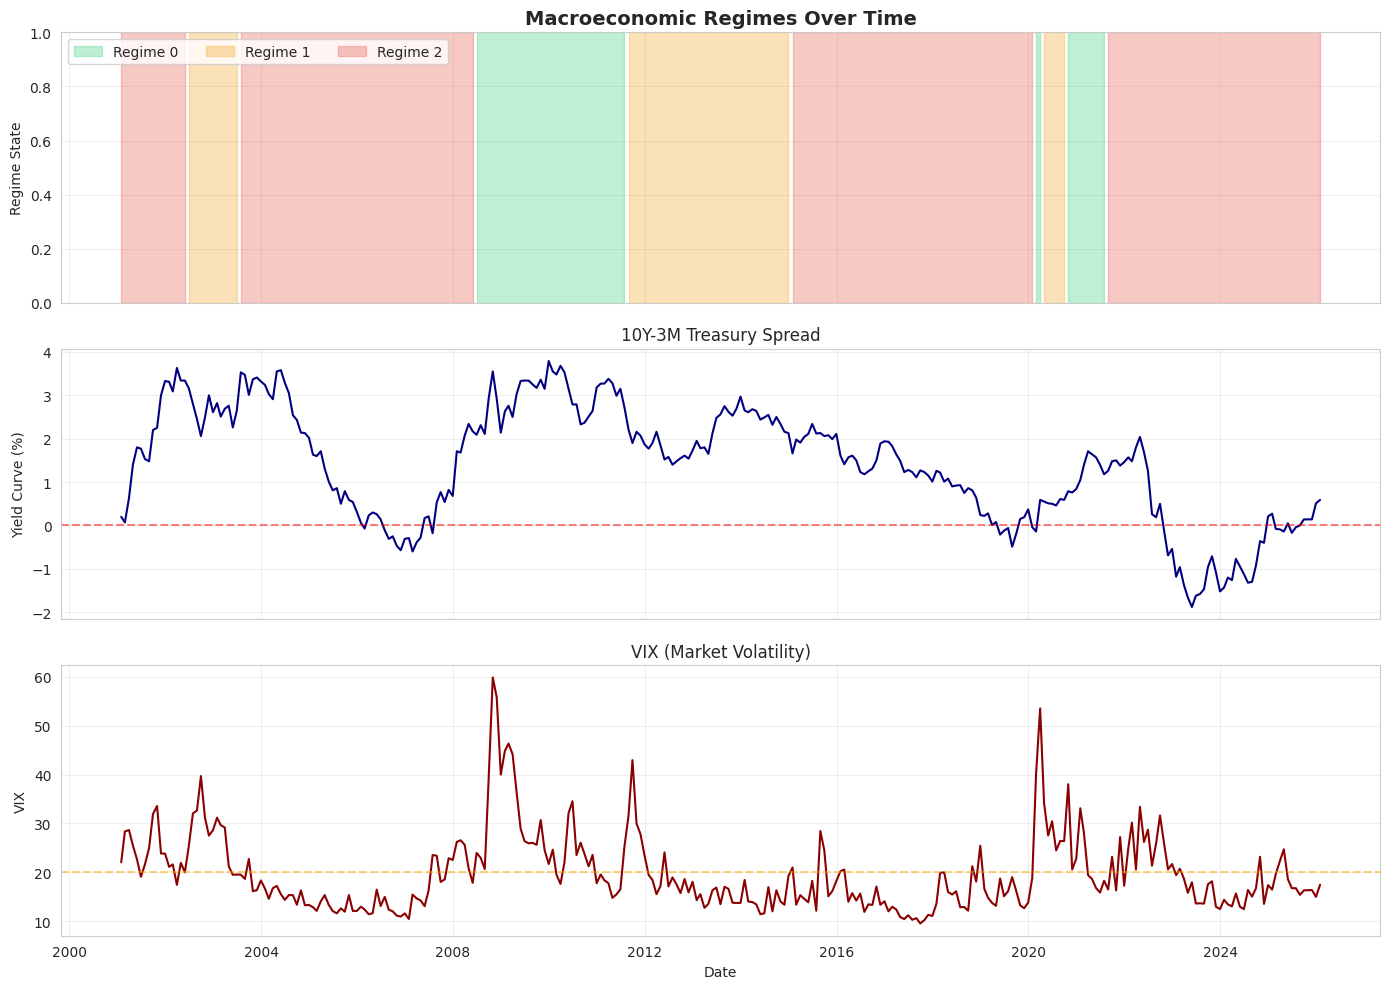

Creating cumulative returns comparison...
  ✓ Saved: regime_allocation_results/cumulative_returns.png


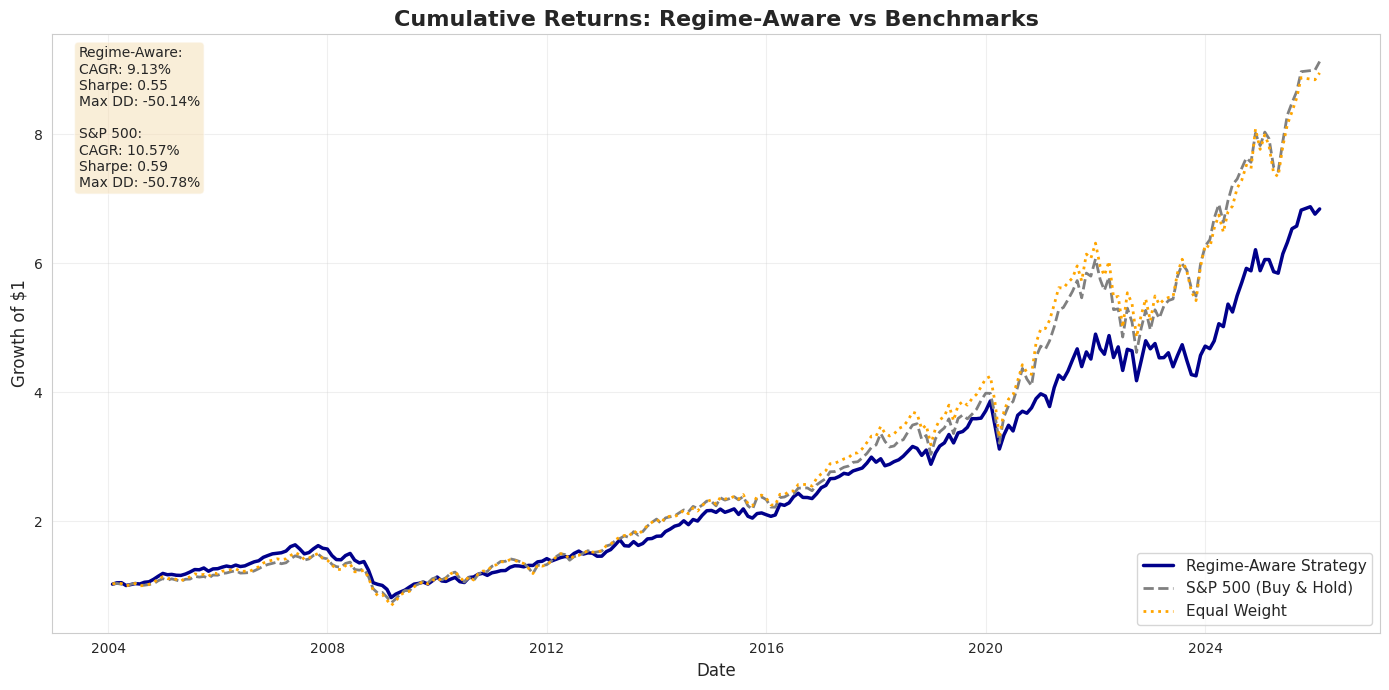

Creating drawdown comparison...
  ✓ Saved: regime_allocation_results/drawdown_comparison.png


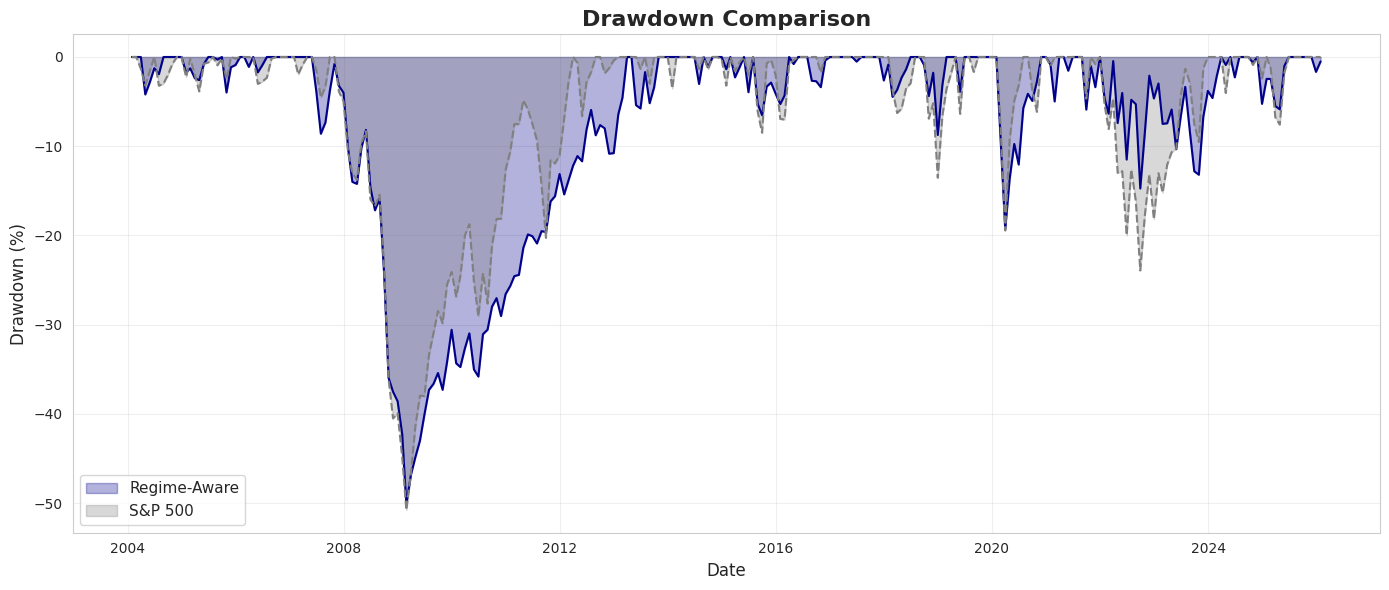

Creating returns by regime plot...
  ✓ Saved: regime_allocation_results/returns_by_regime.png


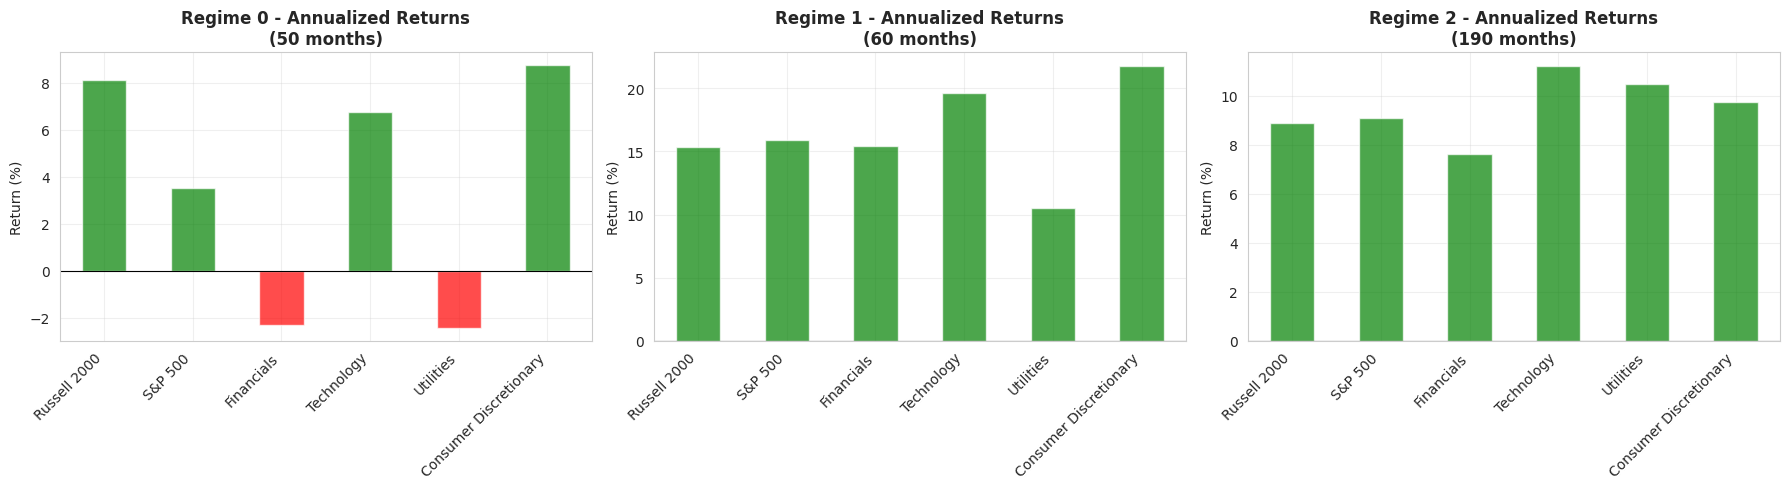

In [17]:
print("\n" + "="*80)
print("PART 6: GENERATING VISUALIZATIONS")
print("="*80)

sns.set_style('whitegrid')

# Plot 1: Regime Timeline
print("\nCreating regime timeline plot...")

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Regime timeline
ax = axes[0]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

for regime in range(N_REGIMES):
    mask = regimes_series == regime
    ax.fill_between(
        regimes_series.index,
        0, 1,
        where=mask,
        alpha=0.3,
        color=colors[regime],
        label=f'Regime {regime}'
    )

ax.set_ylabel('Regime State')
ax.set_ylim(0, 1)
ax.legend(loc='upper left', ncol=3)
ax.set_title('Macroeconomic Regimes Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Yield Curve
ax = axes[1]
df = macro_df.loc[regimes_series.index]
ax.plot(df.index, df['yield_curve'], color='navy', linewidth=1.5)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Yield Curve (%)')
ax.set_title('10Y-3M Treasury Spread', fontsize=12)
ax.grid(True, alpha=0.3)

# VIX
ax = axes[2]
ax.plot(df.index, df['vix'], color='darkred', linewidth=1.5)
ax.axhline(20, color='orange', linestyle='--', alpha=0.5)
ax.set_ylabel('VIX')
ax.set_xlabel('Date')
ax.set_title('VIX (Market Volatility)', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(f'{OUTPUT_DIR}/regime_timeline.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {OUTPUT_DIR}/regime_timeline.png")

plt.show()
plt.close()

# Plot 2: Cumulative Returns
print("Creating cumulative returns comparison...")

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(results.index, results['portfolio_cumulative'],
        label='Regime-Aware Strategy', linewidth=2.5, color='darkblue')
ax.plot(results.index, results['spy_cumulative'],
        label='S&P 500 (Buy & Hold)', linewidth=2, color='gray', linestyle='--')
ax.plot(results.index, results['equal_weight_cumulative'],
        label='Equal Weight', linewidth=2, color='orange', linestyle=':')

ax.set_title('Cumulative Returns: Regime-Aware vs Benchmarks', fontsize=16, fontweight='bold')
ax.set_ylabel('Growth of $1', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add performance text
textstr = f"""Regime-Aware:
CAGR: {metrics['portfolio']['CAGR (%)']:.2f}%
Sharpe: {metrics['portfolio']['Sharpe Ratio']:.2f}
Max DD: {metrics['portfolio']['Max Drawdown (%)']:.2f}%

S&P 500:
CAGR: {metrics['spy']['CAGR (%)']:.2f}%
Sharpe: {metrics['spy']['Sharpe Ratio']:.2f}
Max DD: {metrics['spy']['Max Drawdown (%)']:.2f}%"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(f'{OUTPUT_DIR}/cumulative_returns.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {OUTPUT_DIR}/cumulative_returns.png")
plt.show()
plt.close()

# Plot 3: Drawdown Comparison
print("Creating drawdown comparison...")

def calculate_drawdown(cum_returns):
    running_max = cum_returns.expanding().max()
    return (cum_returns - running_max) / running_max * 100

dd_portfolio = calculate_drawdown(results['portfolio_cumulative'])
dd_spy = calculate_drawdown(results['spy_cumulative'])

fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(dd_portfolio.index, dd_portfolio, 0, alpha=0.3, color='darkblue', label='Regime-Aware')
ax.fill_between(dd_spy.index, dd_spy, 0, alpha=0.3, color='gray', label='S&P 500')

ax.plot(dd_portfolio.index, dd_portfolio, color='darkblue', linewidth=1.5)
ax.plot(dd_spy.index, dd_spy, color='gray', linewidth=1.5, linestyle='--')

ax.set_title('Drawdown Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(f'{OUTPUT_DIR}/drawdown_comparison.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {OUTPUT_DIR}/drawdown_comparison.png")
plt.show()
plt.close()

# Plot 4: Returns by Regime
print("Creating returns by regime plot...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for regime in range(N_REGIMES):
    ax = axes[regime]

    annual_returns = regime_stats[regime]['mean_returns'] * 12
    colors_bar = ['green' if x > 0 else 'red' for x in annual_returns]
    annual_returns.plot(kind='bar', ax=ax, color=colors_bar, alpha=0.7)

    ax.set_title(f'Regime {regime} - Annualized Returns\n({regime_stats[regime]["n_obs"]} months)',
                 fontweight='bold', fontsize=12)
    ax.set_ylabel('Return (%)')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(f'{OUTPUT_DIR}/returns_by_regime.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {OUTPUT_DIR}/returns_by_regime.png")
plt.show()
plt.close()


In [15]:
print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)

print(f"\n✓ All outputs saved to: {OUTPUT_DIR}/")

print("\n QUICK SUMMARY:")
print(f"  • Data: {len(macro_df)} months from {macro_df.index[0].date()} to {macro_df.index[-1].date()}")
print(f"  • Regimes: {N_REGIMES} states detected")
print(f"  • Backtest: {len(results)} out-of-sample periods")
print(f"  • Sharpe Improvement: {metrics['portfolio']['Sharpe Ratio'] - metrics['spy']['Sharpe Ratio']:+.2f}")
print(f"  • Drawdown Reduction: {metrics['spy']['Max Drawdown (%)'] - metrics['portfolio']['Max Drawdown (%)']:+.1f}pp")

print("\n YOUR RESULTS:")
print(f"  Regime-Aware: {metrics['portfolio']['CAGR (%)']:.2f}% CAGR, {metrics['portfolio']['Sharpe Ratio']:.2f} Sharpe")
print(f"  S&P 500 B&H: {metrics['spy']['CAGR (%)']:.2f}% CAGR, {metrics['spy']['Sharpe Ratio']:.2f} Sharpe")




PIPELINE COMPLETE!

✓ All outputs saved to: regime_allocation_results/

 QUICK SUMMARY:
  • Data: 300 months from 2001-01-31 to 2026-01-31
  • Regimes: 3 states detected
  • Backtest: 264 out-of-sample periods
  • Sharpe Improvement: -0.04
  • Drawdown Reduction: -0.6pp

 YOUR RESULTS:
  Regime-Aware: 9.13% CAGR, 0.55 Sharpe
  S&P 500 B&H: 10.57% CAGR, 0.59 Sharpe
